# Gradient boosting classifier for non-proximate travel

**Description:**
This notebook reproduces Figure 4 in the manuscript.
1. **Figure 4a:** SHAP summary plot ranked by feature importance.
2. **Figure 4b-c:** SHAP dependence plot relating experienced
income segregation and POI diversity to the probability of non-proximate travel.

**Data Source:** 
- `data/`

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap

import shap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

# Setup project root path
project_root = Path.cwd()
if 'notebooks' in str(project_root):
    project_root = project_root.parent

# Add src to path
src_path = str(project_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Set results path
data_dir = project_root / 'data'

In [3]:
reg_data = pd.read_parquet(data_dir / "ml_grid.parquet")

## Model tuning

In [4]:
model_vars = [
    'chosen',
    'car_ttm','pt_ttm',
    'diff_amenity_count','diff_div', 'seg_contrast',
    'stay_visit_seg','stay_diversity',
    'stay_city_centre_flag','home_city_centre_flag',
    'log_income','pop_density', 'hed_ratio','over_65_ratio','rent_ratio','non_res_ratio', 'serv_wp_ratio',
]
mod_data = reg_data.dropna(subset=model_vars)

feature_vars = [var for var in model_vars if var != 'chosen']
X = mod_data[feature_vars]
y = mod_data['chosen']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [5]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

xgb_grid.fit(X_train, y_train)


tuned_model = xgb_grid.best_estimator_
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test set Accuracy: {tuned_model.score(X_test, y_test):.4f}")
print(f"Test set AUC-ROC: {test_auc:.4f}")



Test set Accuracy: 0.8944
Test set AUC-ROC: 0.9478


In [6]:
# SHAP values for the XGBoost model
# We used the whole dataset (X) to explain the overall patterns in the model.

explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(X)


## Fig 4a. SHAP summary plot

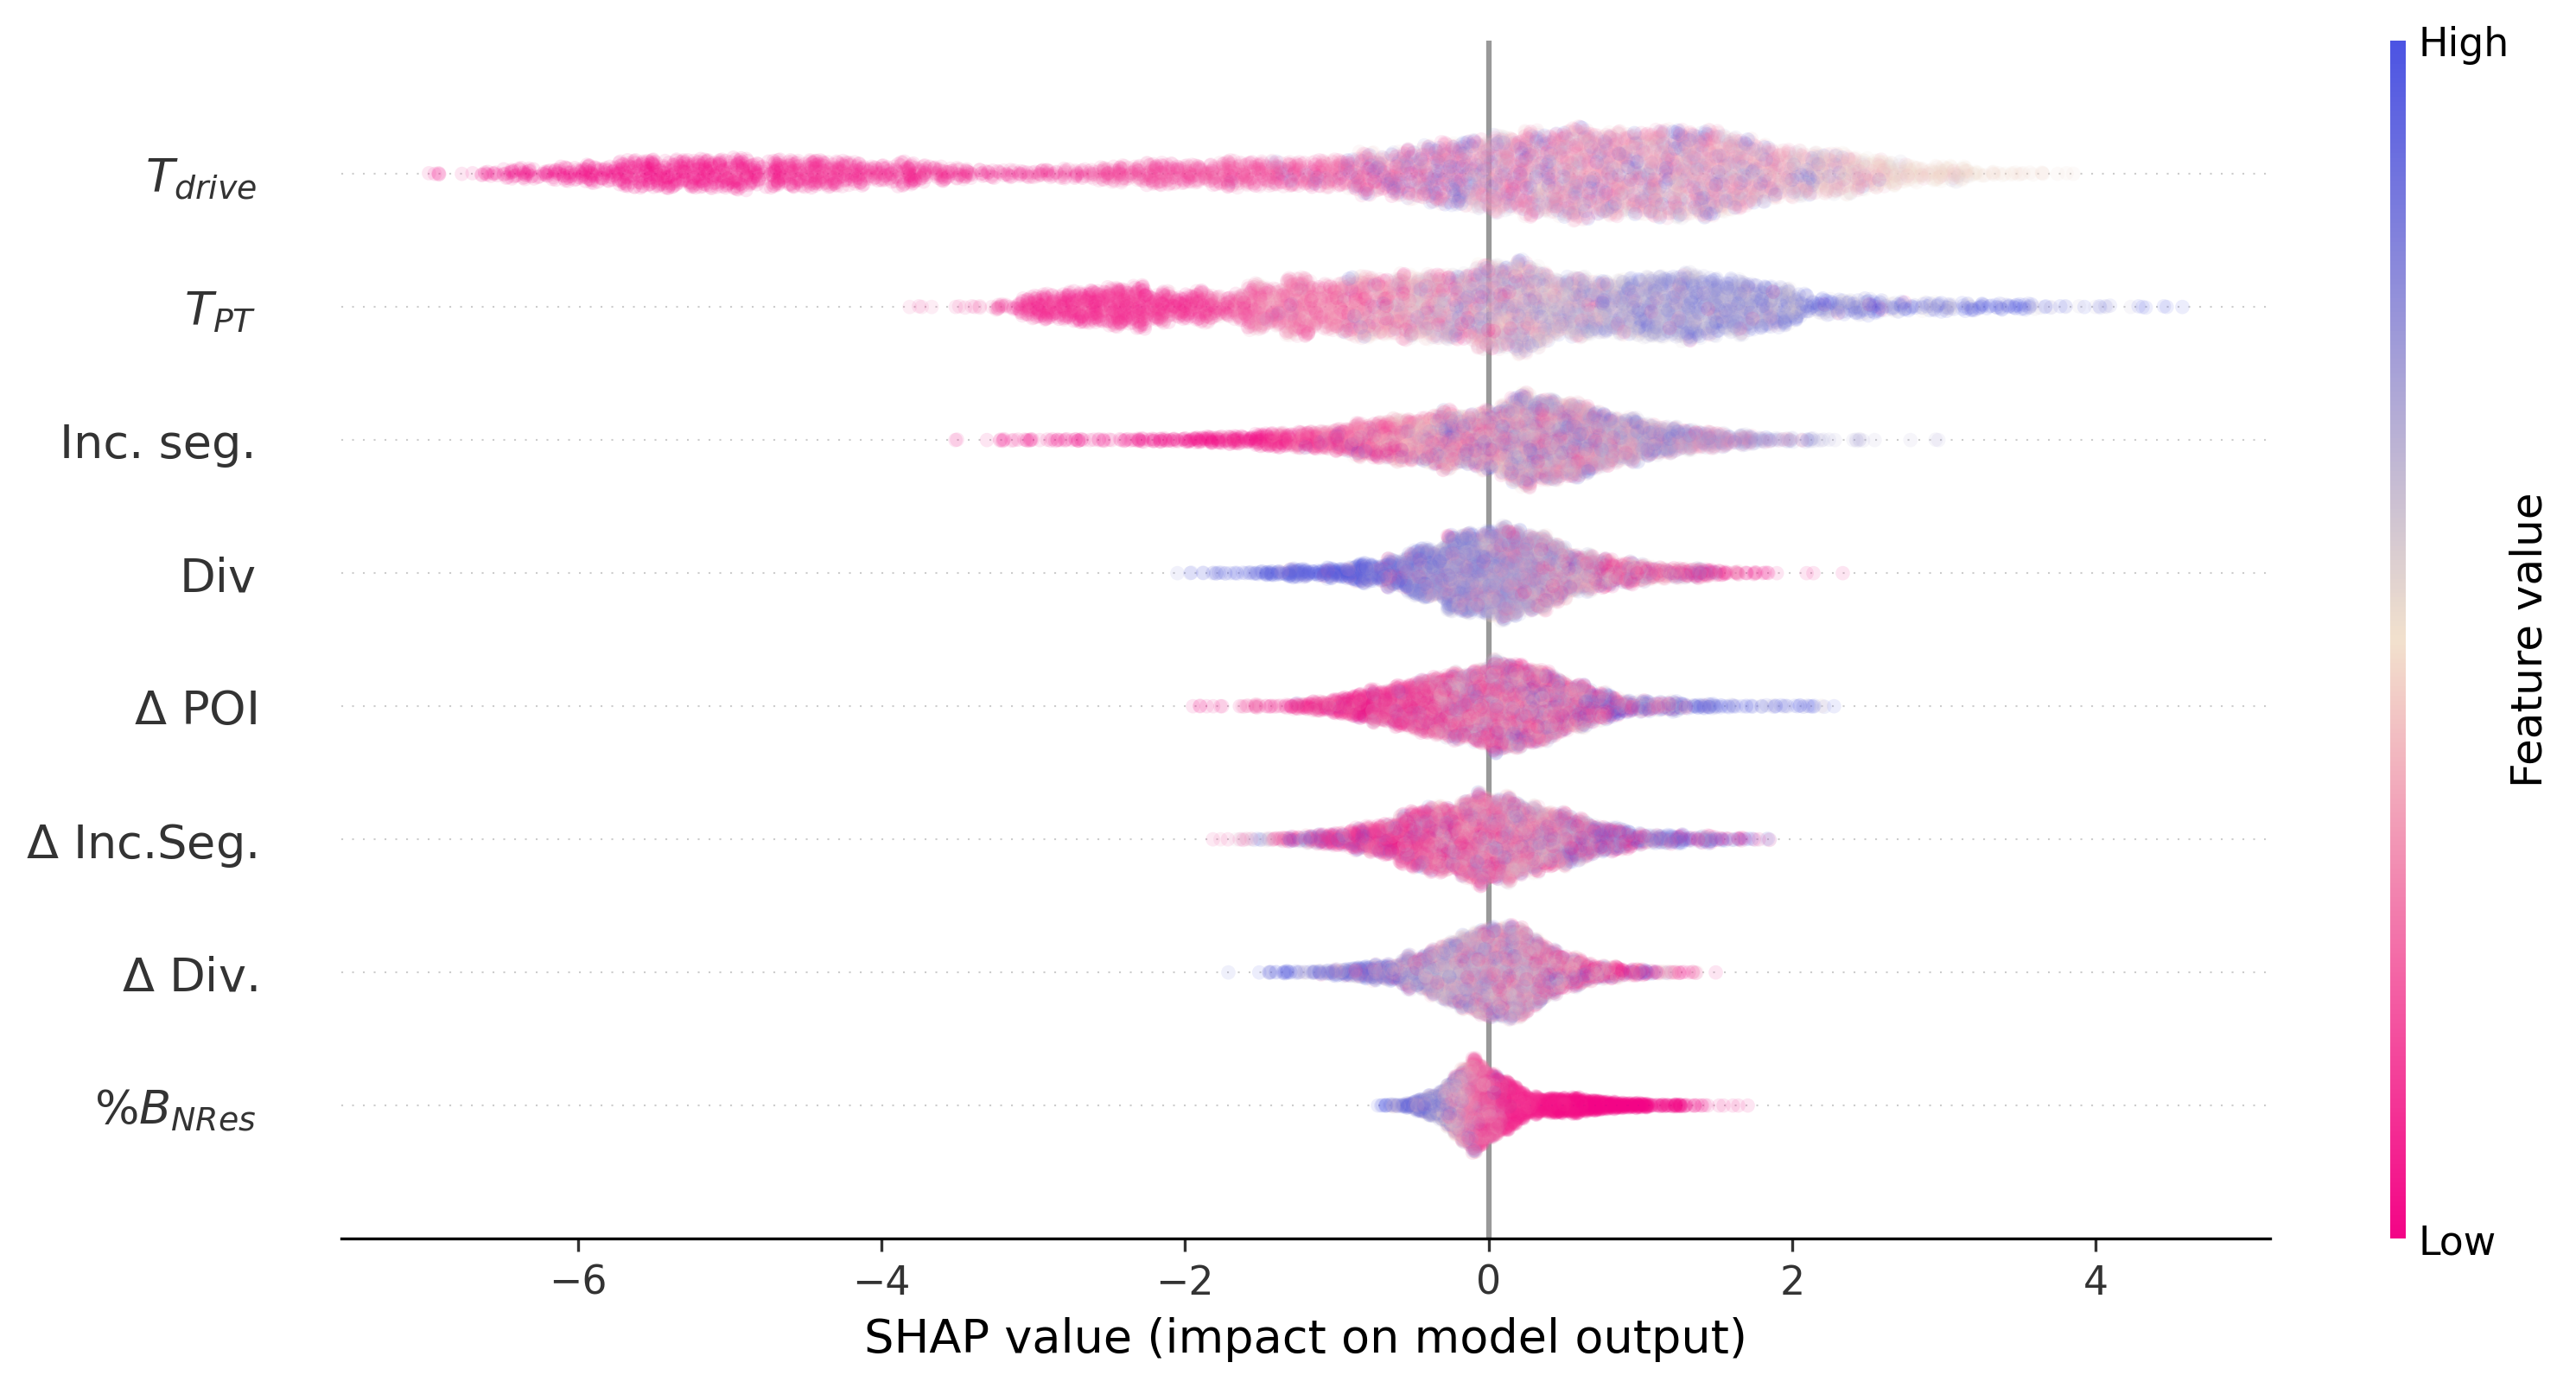

In [7]:
feature_names = [
    r'$T_{drive}$', r'$T_{PT}$', r'$\Delta$ POI', r'$\Delta$ Div.',
    r'$\Delta$ Inc.Seg.', 'Inc. seg.', 'Div', 'Dest. in centre',
    'Home in centre', 'Median Income', 'Popu. density', '% Bachelor plus',
    '% Over 65', '% Household, Renting', r'$\%B_{NRes}$', '% Service workplaces'
]

explanation = shap.Explanation(
    values=shap_values,
    data=X,
    feature_names=feature_names
)

colors = ['#F30486', '#F2E1CD', '#4C54E3']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

shap.plots.beeswarm(
    explanation,
    max_display=8,
    color=custom_cmap,
    alpha=0.1,
    s=16,
    ax=ax1,
    show=False,
    plot_size=None,
    group_remaining_features=False
)

plt.show()


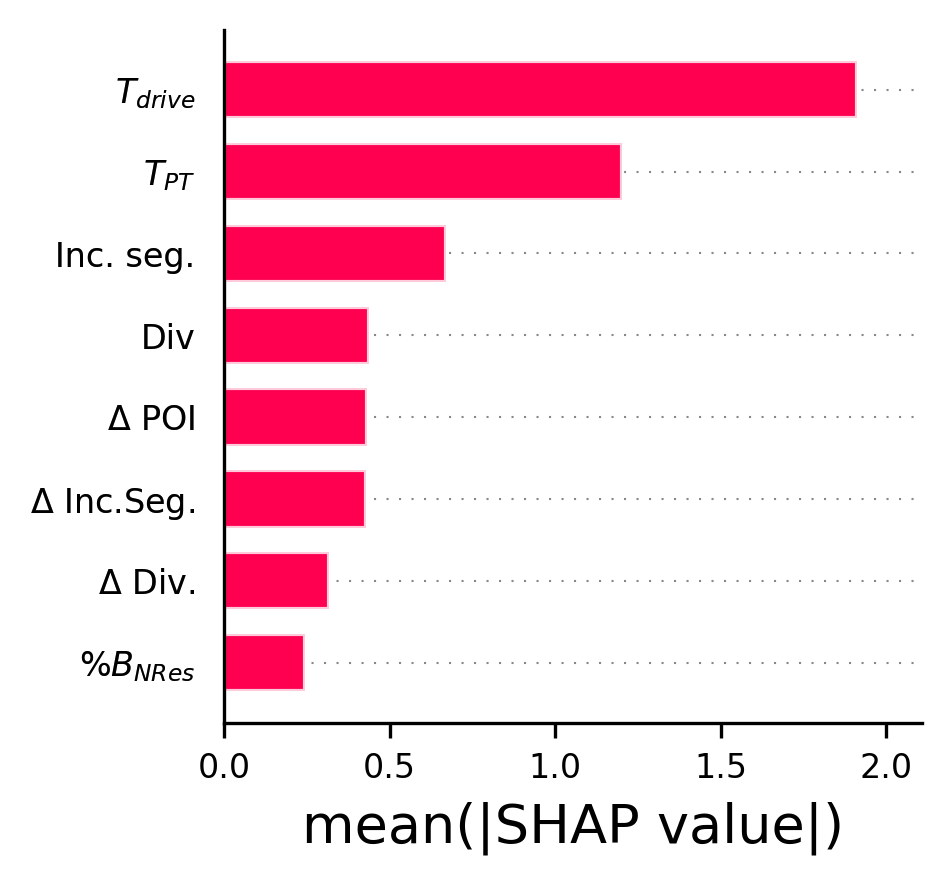

In [8]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

global_importance = explanation.abs.mean(0)
top_indices = np.argsort(-global_importance.values)[:8]
top_features = global_importance[top_indices]

shap.plots.bar(
    top_features,
    max_display=8,
    ax=ax,
    show_data=False,
    show=False
)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_ylabel(ax.get_ylabel(), fontsize=8)

for txt in ax.texts:
    if txt.get_text().startswith(('+', '-')):
        txt.set_visible(False)

# plt.xlabel("Mean abs. SHAP value",fontsize=8)
plt.show()


## Fig 4b-c. SHAP dependence plot

In [9]:
explanation_original = shap.Explanation(
    values=shap_values,
    data=X.values,
    feature_names=feature_names
)


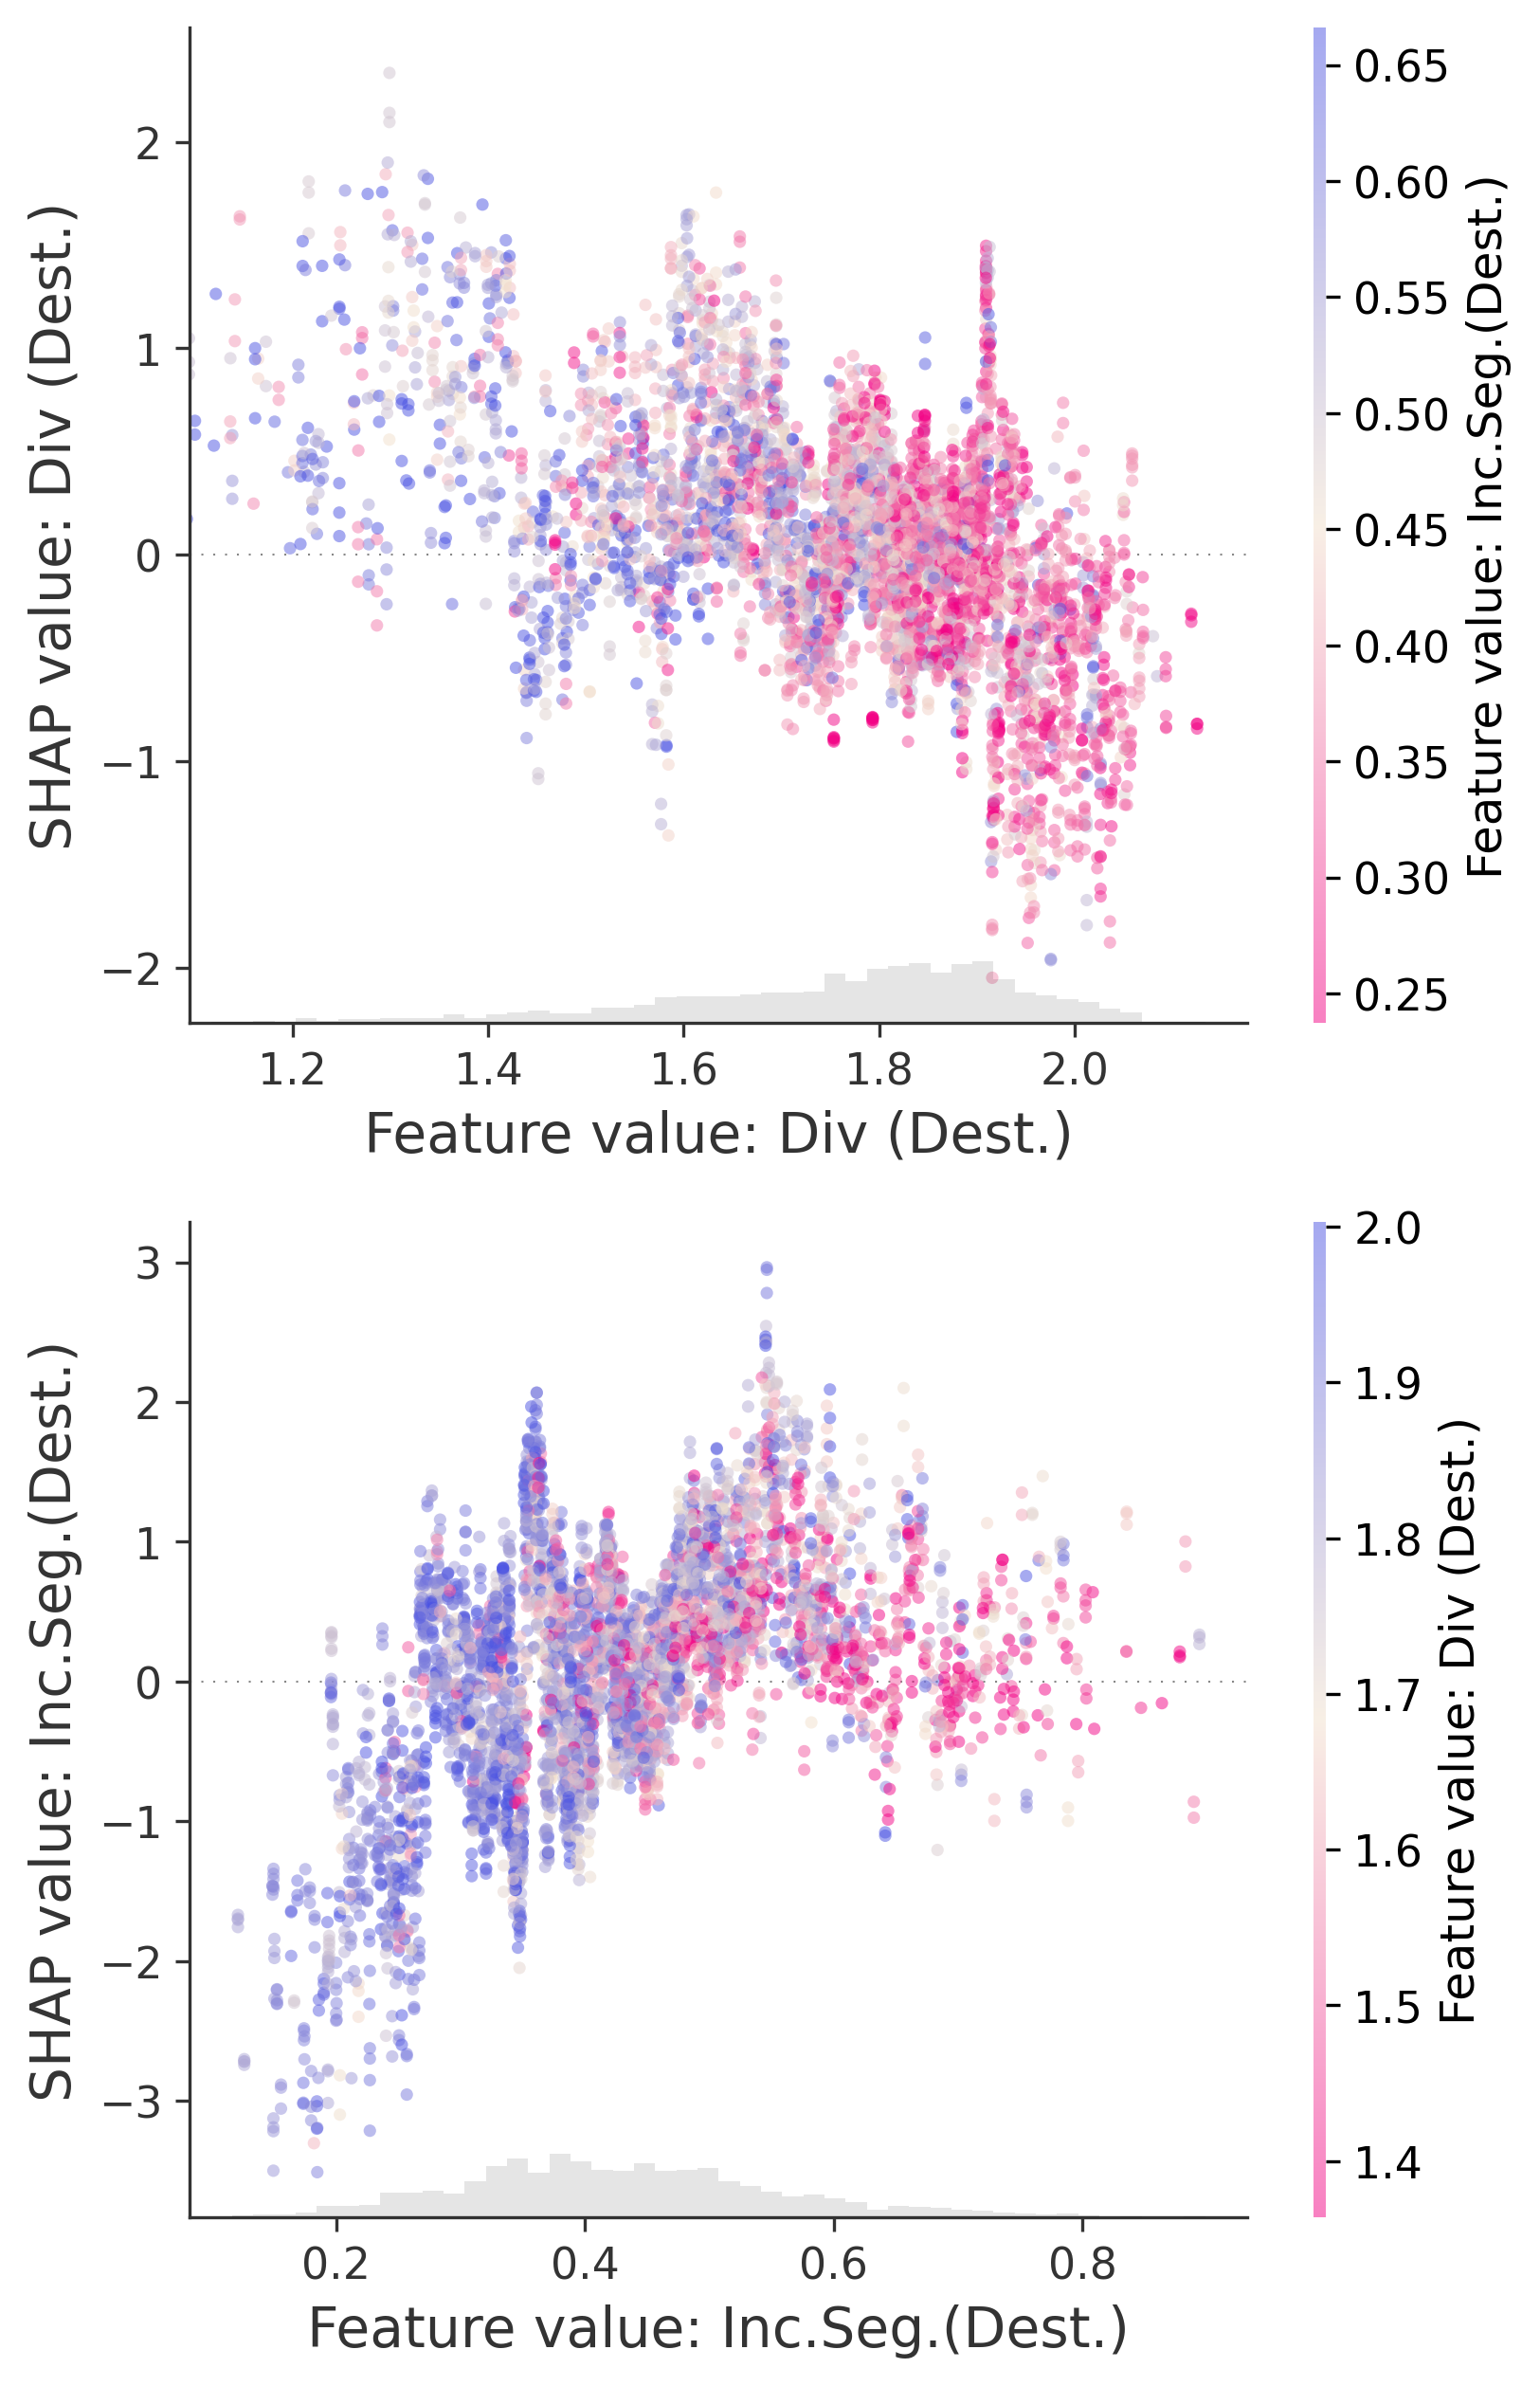

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

colors = ['#F30486','#F2E1CD','#4C54E3']

cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

scatter_cmap = cmap

if 'explanation_original' not in locals() or explanation_original is None:
    explanation_original = shap.Explanation(
        values=shap_values_no_tt,
        data=X_no_tt.values,
        feature_names=feature_names
    )

fig, axes = plt.subplots(2, 1, figsize=(6, 10), dpi=300)

shap.plots.scatter(
    explanation_original[:, 'Div'],
    color=explanation_original[:, 'Inc. seg.'],
    ax=axes[0],
    cmap=scatter_cmap,
    show=False,
    alpha=0.5,
    dot_size=10,
    hist=True,
    x_jitter='auto',
    xmin=explanation_original[:, 'Div'].percentile(1)
)
axes[0].set_xlabel('Feature value: Div (Dest.)', fontsize=14)
axes[0].set_ylabel('SHAP value: Div (Dest.)', fontsize=14)

shap.plots.scatter(
    explanation_original[:, 'Inc. seg.'],
    color=explanation_original[:, 'Div'],
    ax=axes[1],
    cmap=scatter_cmap,
    show=False,
    alpha=0.5,
    dot_size=10,
    hist=True,
    x_jitter='auto'
)
axes[1].set_xlabel('Feature value: Inc.Seg.(Dest.)', fontsize=14)
axes[1].set_ylabel('SHAP value: Inc.Seg.(Dest.)', fontsize=14)

if len(axes[0].collections) > 0:
    cbar = axes[0].collections[0].colorbar
    if cbar: cbar.set_label('Feature value: Inc.Seg.(Dest.)', fontsize=12)

if len(axes[1].collections) > 0:
    cbar2 = axes[1].collections[0].colorbar
    if cbar2: cbar2.set_label('Feature value: Div (Dest.)', fontsize=12)

# plt.savefig('figures/shap-dependence-plots.svg')
plt.show()


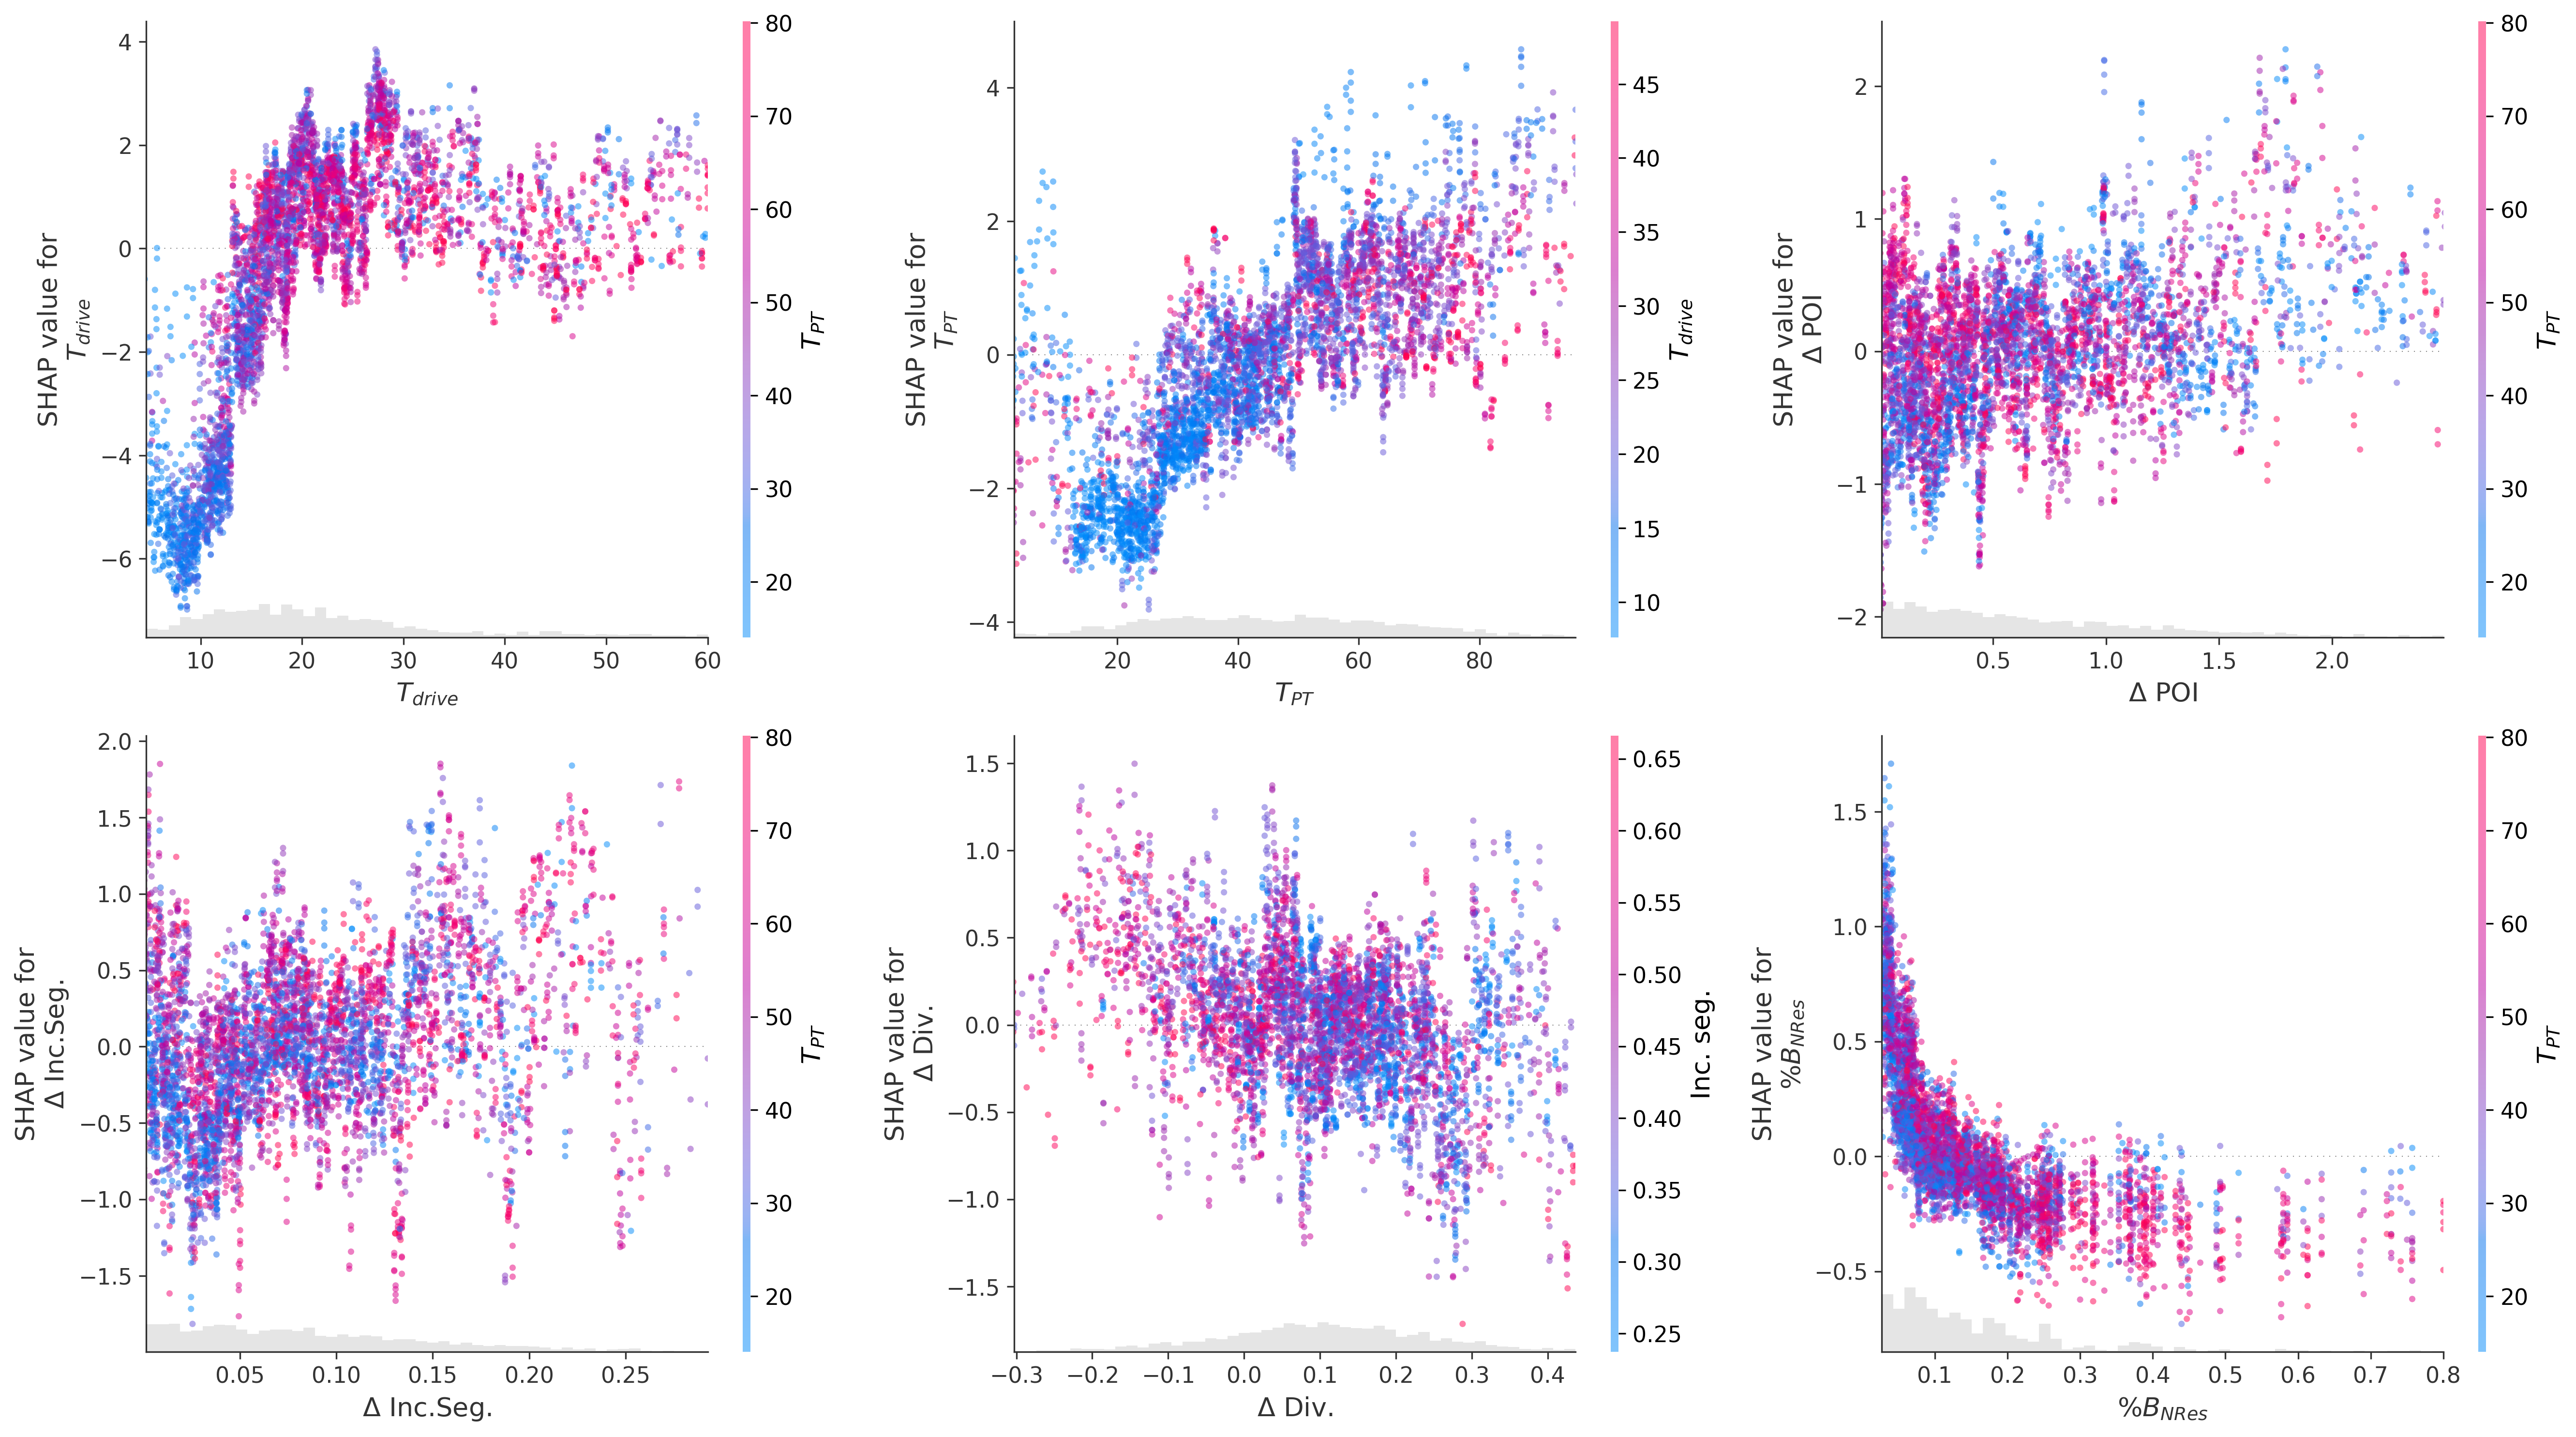

In [11]:

explanation_original = shap.Explanation(
    values=shap_values,
    data=X.values,
    feature_names=feature_names
)

feature_importance = np.abs(explanation_original.values).mean(axis=0)

import pandas as pd
importance_df = pd.DataFrame({
    'feature_name': explanation_original.feature_names,
    'importance': feature_importance
})

excluded = ['Inc. seg.', 'Div']
filtered_df = importance_df[~importance_df['feature_name'].isin(excluded)].sort_values('importance', ascending=False)

top_6_features = filtered_df.head(6)['feature_name'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=300)
axes = axes.flatten()

for i, feature in enumerate(top_6_features):
    shap.plots.scatter(
        explanation_original[:, feature],
        ax=axes[i],
        show=False,
        color=explanation_original,
        dot_size=10,
        alpha=0.5,
        xmin=explanation_original[:, feature].percentile(1),
        xmax=explanation_original[:, feature].percentile(99),
    )

plt.tight_layout()
plt.show()


# Supplementary: Modeling without Travel Time Features

Re-run the XGBoost model excluding `car_ttm` and `pt_ttm`.

In [12]:
model_vars_no_tt = [
    'chosen',
    'diff_amenity_count','diff_div', 'seg_contrast',
    'stay_visit_seg','stay_diversity',
    'stay_city_centre_flag','home_city_centre_flag',
    'log_income','pop_density', 'hed_ratio','over_65_ratio','rent_ratio','non_res_ratio', 'serv_wp_ratio',
]

mod_data_no_tt = reg_data.dropna(subset=model_vars_no_tt)


feature_vars_no_tt = [var for var in model_vars_no_tt if var != 'chosen']
X_no_tt = mod_data_no_tt[feature_vars_no_tt]
y_no_tt = mod_data_no_tt['chosen']

X_train_no_tt, X_test_no_tt, y_train_no_tt, y_test_no_tt = train_test_split(
    X_no_tt, y_no_tt, test_size=0.2, random_state=42, stratify=y_no_tt
)



In [13]:

xgb_grid_no_tt = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

xgb_grid_no_tt.fit(X_train_no_tt, y_train_no_tt)


tuned_model_no_tt = xgb_grid_no_tt.best_estimator_

y_pred_proba_no_tt = tuned_model_no_tt.predict_proba(X_test_no_tt)[:, 1]
test_auc_no_tt = roc_auc_score(y_test_no_tt, y_pred_proba_no_tt)

print(f"Test set Accuracy (without travel time): {tuned_model_no_tt.score(X_test_no_tt, y_test_no_tt):.4f}")
print(f"Test set ROC-AUC (without travel time): {test_auc_no_tt:.4f}")



Test set Accuracy (without travel time): 0.8197
Test set ROC-AUC (without travel time): 0.8793


In [ ]:
explainer_no_tt = shap.TreeExplainer(tuned_model_no_tt)
shap_values_no_tt = explainer_no_tt.shap_values(X_no_tt)

In [15]:
shap_importance_no_tt = np.abs(shap_values_no_tt).mean(axis=0)
feature_importance_no_tt_df = pd.DataFrame({
    'Feature': feature_vars_no_tt,
    'SHAP Importance': shap_importance_no_tt
}).sort_values('SHAP Importance', ascending=False)



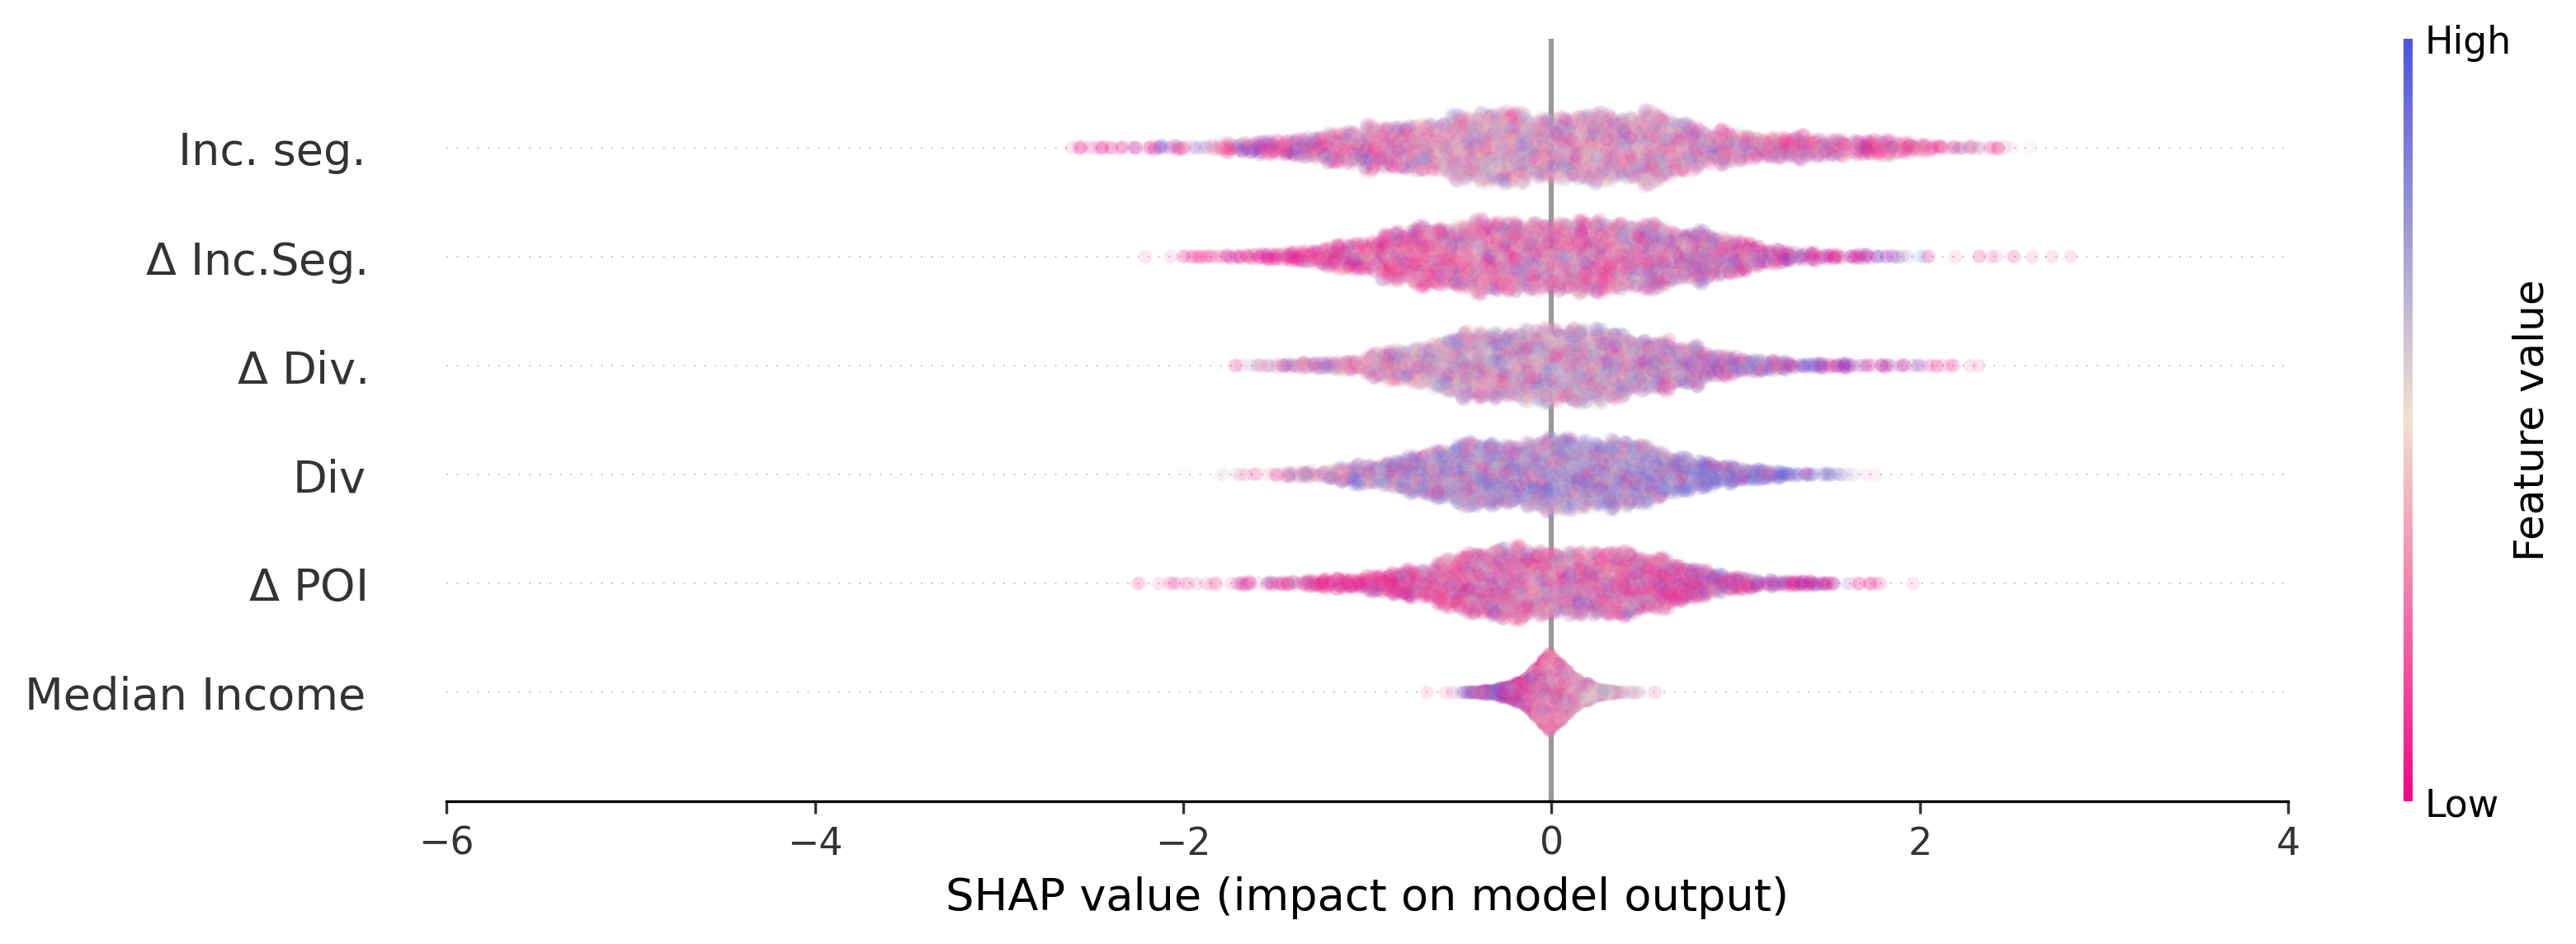

In [16]:
feature_names = [
    r'$\Delta$ POI', r'$\Delta$ Div.',
    r'$\Delta$ Inc.Seg.', 'Inc. seg.', 'Div', 'Dest. in centre',
    'Home in centre', 'Median Income', 'Popu. density', '% Bachelor plus',
    '% Over 65', '% Household, Renting', r'$\%B_{NRes}$', '% Service workplaces'
]

explanation = shap.Explanation(
    values=shap_values_no_tt,
    data=X_no_tt,
    feature_names=feature_names
)

colors = ['#F30486', '#F2E1CD', '#4C54E3']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

fig, ax1 = plt.subplots(figsize=(12, 4), dpi=300)

shap.plots.beeswarm(
    explanation,
    max_display=6,
    color=custom_cmap,
    alpha=0.1,
    s=16,
    ax=ax1,
    show=False,
    plot_size=None,
    group_remaining_features=False,
)

ax1.set_xlim(-6,4)
plt.show()



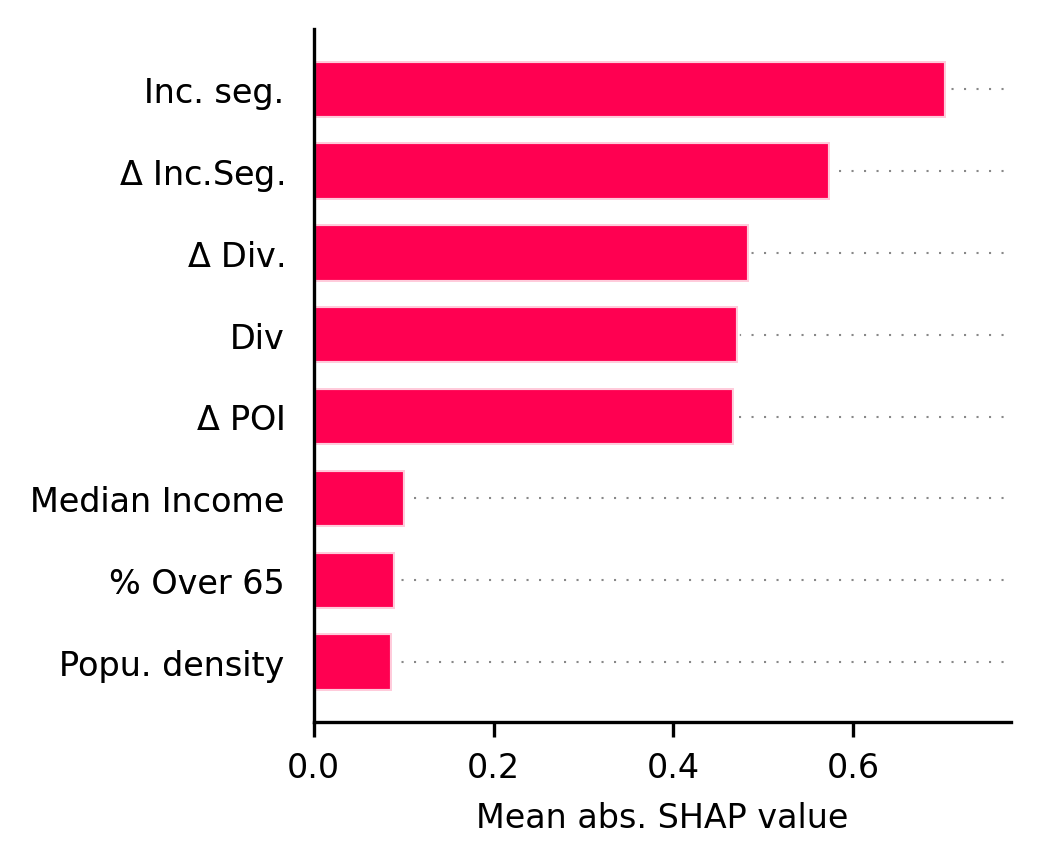

In [17]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

global_importance = explanation.abs.mean(0)
top_indices = np.argsort(-global_importance.values)[:8]
top_features = global_importance[top_indices]

shap.plots.bar(
    top_features,
    max_display=8,
    ax=ax,
    show_data=False,
    show=False
)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_ylabel(ax.get_ylabel(), fontsize=8)

for txt in ax.texts:
    if txt.get_text().startswith(('+', '-')):
        txt.set_visible(False)

plt.xlabel("Mean abs. SHAP value",fontsize=8)
plt.show()
